In [2]:
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re

## MedMCQA

In [3]:
res = pd.read_csv('/Users/linxy29/Documents/Data/GeneRAG/benchmark/MedMCQA/combined_results.csv')
# Extract numbers followed by confidence scores (e.g., '3(0.95)')
res['option_res'] = res['answer'].str.extract(r'([1-4])\(0?\.\d+\)', expand=False)

# Fill missing values by extracting standalone numbers (1-4)
res['option_res'] = res['option_res'].fillna(
    res['answer'].str.extract(r'\b([1-4])\b', expand=False)
)

# Convert to numeric (optional, converts to float; use 'Int64' for nullable integer type)
res['option_res'] = pd.to_numeric(res['option_res'], errors='coerce')
print(res.head())

  error                                    model  \
0   NaN                                   gpt-4o   
1   NaN                            deepseek-chat   
2   NaN                        deepseek-reasoner   
3   NaN  meta-llama/Meta-Llama-3.1-405B-Instruct   
4   NaN                Qwen/Qwen2.5-72B-Instruct   

                                            question   answer  confidence  \
0  Please choice the correct option (1, 2, 3 or 4...      1.0        0.85   
1  Please choice the correct option (1, 2, 3 or 4...   1(0.8)        0.80   
2  Please choice the correct option (1, 2, 3 or 4...  1(0.95)        0.95   
3  Please choice the correct option (1, 2, 3 or 4...        1        0.95   
4  Please choice the correct option (1, 2, 3 or 4...        1        0.95   

                                           reasoning  time_taken  \
0  The basilar artery is a single, unpaired struc...       2.178   
1                                                NaN       3.067   
2  Okay, let's try t

In [4]:
file_path = "/Users/linxy29/Documents/Data/GeneRAG/benchmark/MedMCQA/dev.json"
# Read the file line by line and parse each JSON object
data = []
with open(file_path, "r", encoding="utf-8") as file:
    for line in file:
        try:
            json_obj = json.loads(line.strip())  # Parse each line as JSON
            data.append(json_obj)  # Append to the list
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")
# Convert the list of JSON objects into a DataFrame
input_df = pd.DataFrame(data)
print(input_df.head())

                                            question  \
0  Which of the following is not true for myelina...   
1  Which of the following is not true about glome...   
2  A 29 yrs old woman with a pregnancy of 17 week...   
3                               Axonal transport is:   
4  Low insulin to glucagon ratio is seen in all o...   

                                                 exp  cop  \
0                                               None    1   
1  Ans-a. The oncotic pressure of the fluid leavi...    1   
2                                               None    3   
3  Fast anterograde (400 mm/day) transport occurs...    3   
4  Answer- A. Glycogen synthesisLow insulin to gl...    1   

                                                 opa  \
0  Impulse through myelinated fibers is slower th...   
1  The oncotic pressure of the fluid leaving the ...   
2  No test is required now as her age is below 35...   
3                                          Antegrade   
4               

In [5]:
res = res.merge(input_df[['id', 'subject_name', 'cop']], on='id', how='left')
print(res.head())

  error                                    model  \
0   NaN                                   gpt-4o   
1   NaN                            deepseek-chat   
2   NaN                        deepseek-reasoner   
3   NaN  meta-llama/Meta-Llama-3.1-405B-Instruct   
4   NaN                Qwen/Qwen2.5-72B-Instruct   

                                            question   answer  confidence  \
0  Please choice the correct option (1, 2, 3 or 4...      1.0        0.85   
1  Please choice the correct option (1, 2, 3 or 4...   1(0.8)        0.80   
2  Please choice the correct option (1, 2, 3 or 4...  1(0.95)        0.95   
3  Please choice the correct option (1, 2, 3 or 4...        1        0.95   
4  Please choice the correct option (1, 2, 3 or 4...        1        0.95   

                                           reasoning  time_taken  \
0  The basilar artery is a single, unpaired struc...       2.178   
1                                                NaN       3.067   
2  Okay, let's try t

## Load data

In [6]:
res['model'] = res['model'].replace({
    'Qwen/Qwen2.5-72B-Instruct': 'Qwen2.5-72B',  
    'deepseek-ai/DeepSeek-R1-Distill-Llama-8B': 'Distill-Llama-8B',
    'deepseek-ai/DeepSeek-R1-Distill-Qwen-7B': 'Distill-Qwen-7B',  
    'deepseek-chat': 'DeepSeek-V3',
    'deepseek-reasoner': 'DeepSeek-R1',  
    'meta-llama/Meta-Llama-3.1-405B-Instruct': 'Llama-3.1-405B',
    'gpt-4o': 'GPT-4o'
})

### Performance

In [7]:
res = res[res['answer'].notna()]
res['correct'] = res['option_res'] == res['cop']
acc_df = res.groupby(['model', 'subject_name'])['correct'].mean().reset_index()
acc_df.rename(columns={'correct': 'accuracy'}, inplace=True)
print(acc_df)

           model                  subject_name  accuracy
0    DeepSeek-R1                   Anaesthesia  0.928571
1    DeepSeek-R1                       Anatomy  0.875000
2    DeepSeek-R1                  Biochemistry  0.951807
3    DeepSeek-R1                        Dental  0.669643
4    DeepSeek-R1                           ENT  0.863636
..           ...                           ...       ...
142  Qwen2.5-72B                     Radiology  0.600000
143  Qwen2.5-72B                          Skin  0.333333
144  Qwen2.5-72B  Social & Preventive Medicine  0.616667
145  Qwen2.5-72B                       Surgery  0.625767
146  Qwen2.5-72B                       Unknown  0.500000

[147 rows x 3 columns]


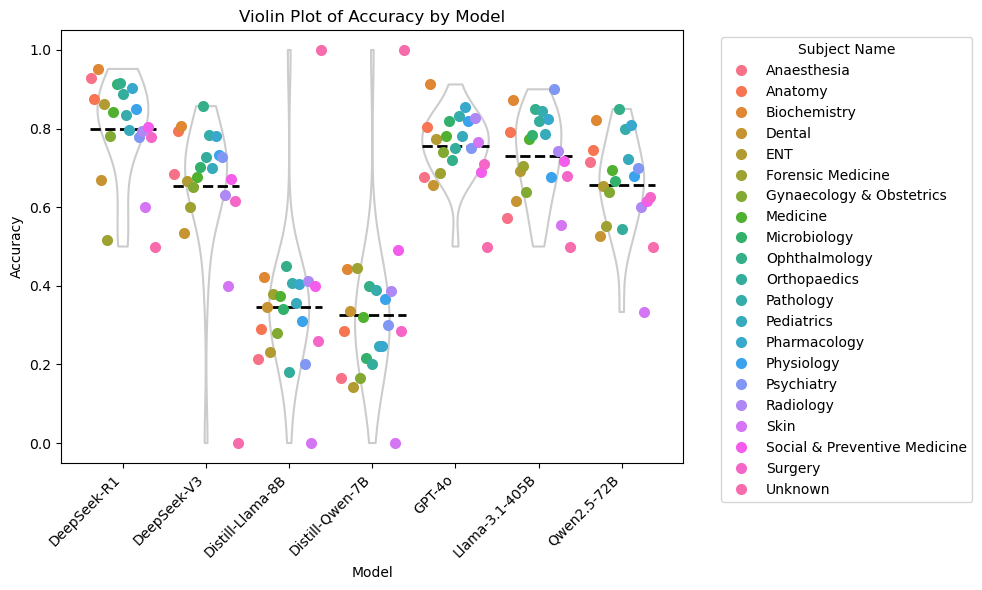

In [8]:
#acc_df = pd.read_csv("/Users/linxy29/Documents/Data/GeneRAG/benchmark/MedMCQA/combined_results_evaluation.csv")
# -------------------------------------------
# 2) Plot violin plot: x = model, y = accuracy; overlay dots for each subject coloured by subject_name
# -------------------------------------------
plt.figure(figsize=(10, 6))

# Define a consistent order for models (alphabetical order here)
model_order = sorted(acc_df['model'].unique())

# Create the violin plot
sns.violinplot(x='model', y='accuracy', data=acc_df, inner=None, color=".8", order=model_order, fill=False,
               cut=0)

# Overlay individual data points (each subject) with stripplot
sns.stripplot(x='model', y='accuracy', data=acc_df, hue='subject_name',
              dodge=True, jitter=True, size=8, order=model_order)

# Compute the overall mean accuracy for each model and draw horizontal dashed lines.
model_means = acc_df.groupby('model')['accuracy'].mean().reset_index()
for i, model in enumerate(model_order):
    # Get the mean accuracy for the current model
    mean_val = model_means.loc[model_means['model'] == model, 'accuracy'].values[0]
    # Draw a horizontal line: x positions span from (i - 0.4) to (i + 0.4)
    plt.hlines(mean_val, i - 0.4, i + 0.4, colors='black', linestyles='--', lw=2)

plt.title('Violin Plot of Accuracy by Model')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.legend(title='Subject Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Time taken

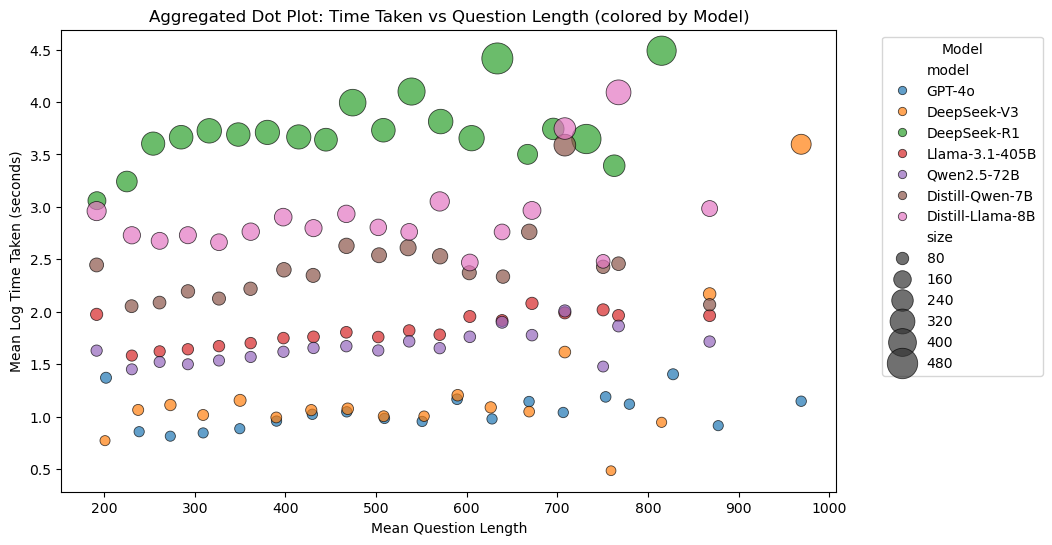

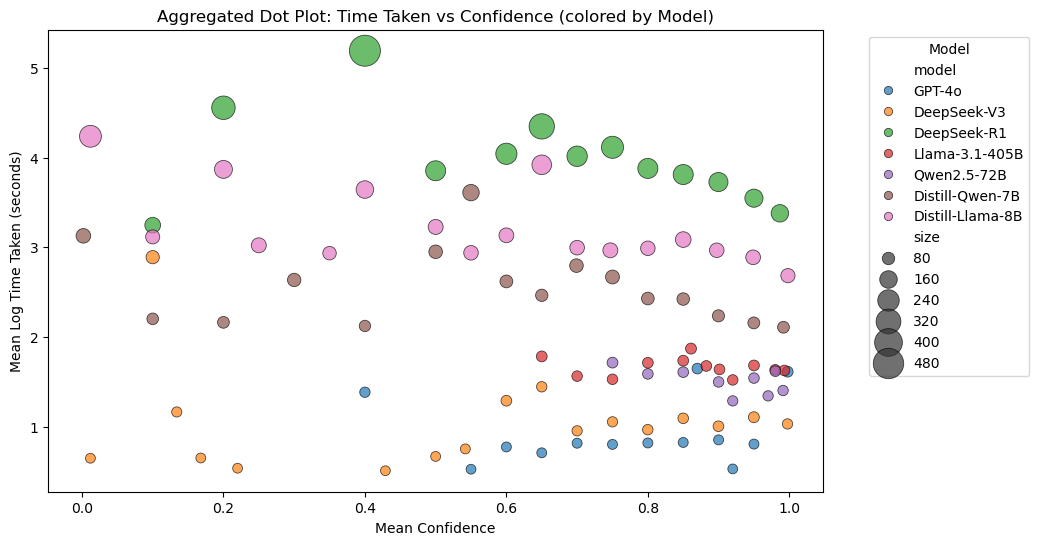

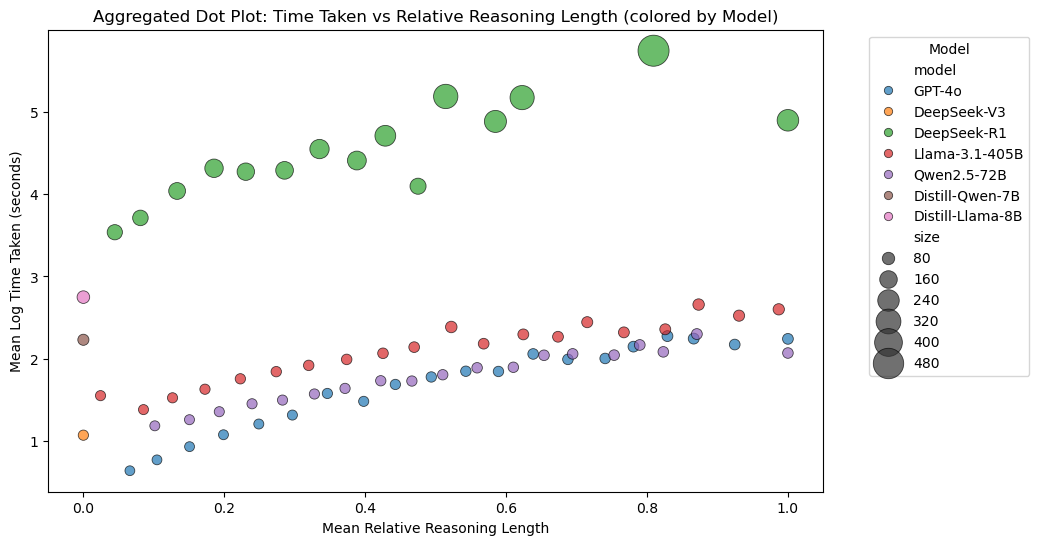

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assume res is your DataFrame with these columns:
# 'model', 'time_taken', 'question_length', 'confidence', and 'reasoning'.
# And that you have computed:
res['log_time'] = np.log(res['time_taken'])
res['question_length'] = res['question'].apply(len)

# Compute relative reasoning length (if not already computed)
max_reasoning_lengths = res.groupby('model')['reasoning'].apply(
    lambda x: x.apply(lambda r: len(str(r)) if isinstance(r, str) else 0).max()
)
res['reasoning_length'] = res['reasoning'].apply(lambda x: len(str(x)) if isinstance(x, str) else 0)
res['relative_reasoning_length'] = res.apply(
    lambda row: row['reasoning_length'] / max_reasoning_lengths[row['model']]
    if row['reasoning_length'] > 0 else 0,
    axis=1
)

# For confidence, we work with a filtered version (confidence values <= 1)
df_filtered_confidence = res[res['confidence'] <= 1].copy()

# ---- Aggregation Function ----
def aggregate_by_variable(df, var, bins=20):
    """
    For each model in df, split the data into `bins` groups based on the variable `var`.
    Returns a DataFrame with the aggregated means:
      - mean_time_taken: mean raw time (for dot size)
      - mean_log_time: mean log(time) (for y-axis)
      - mean_var: mean value of the chosen variable (for x-axis)
    Also returns the model label.
    """
    agg_list = []
    for model in df['model'].unique():
        sub = df[df['model'] == model].copy()
        # Bin the variable into 'bins' groups (using equal-width bins)
        sub[f'{var}_bin'] = pd.cut(sub[var], bins=bins, labels=False)
        grouped = sub.groupby(f'{var}_bin').agg(
            mean_time_taken=('time_taken', 'mean'),
            mean_log_time=('log_time', 'mean'),
            mean_var=(var, 'mean')
        ).reset_index()
        grouped['model'] = model
        # Ensure bin index is integer (optional)
        grouped[f'{var}_bin'] = grouped[f'{var}_bin'].astype(int)
        agg_list.append(grouped)
    agg_df = pd.concat(agg_list, ignore_index=True)
    # For plotting, let x be the aggregated mean of the chosen variable
    agg_df['x'] = agg_df['mean_var']
    return agg_df

# ---- Dot Size Scaling Function ----
def map_sizes(s, min_size=50, max_size=500):
    """Scale series s linearly to the range [min_size, max_size]."""
    s_norm = (s - s.min()) / (s.max() - s.min() + 1e-6)
    return s_norm * (max_size - min_size) + min_size

# ---- Plotting ----
# We use seaborn.scatterplot so that 'hue' (model) is handled as a categorical variable.
# Adjust size range and palette as needed. For categorical hue, a palette like 'tab10' works well.

scale_min = 50   # minimum marker size
scale_max = 500  # maximum marker size

##############################
# Plot 1: x axis is Question/Input Length, dot color indicates Model
##############################
agg_question = aggregate_by_variable(res, 'question_length', bins=20)
agg_question['size'] = map_sizes(agg_question['mean_time_taken'], scale_min, scale_max)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=agg_question,
    x='x', y='mean_log_time',
    hue='model',
    size='size', sizes=(scale_min, scale_max),
    palette='tab10',
    alpha=0.7,
    edgecolor='black'
)
plt.xlabel("Mean Question Length")
plt.ylabel("Mean Log Time Taken (seconds)")
plt.title("Aggregated Dot Plot: Time Taken vs Question Length (colored by Model)")
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

##############################
# Plot 2: x axis is Confidence, dot color indicates Model
##############################
agg_conf = aggregate_by_variable(df_filtered_confidence, 'confidence', bins=20)
agg_conf['size'] = map_sizes(agg_conf['mean_time_taken'], scale_min, scale_max)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=agg_conf,
    x='x', y='mean_log_time',
    hue='model',
    size='size', sizes=(scale_min, scale_max),
    palette='tab10',
    alpha=0.7,
    edgecolor='black'
)
plt.xlabel("Mean Confidence")
plt.ylabel("Mean Log Time Taken (seconds)")
plt.title("Aggregated Dot Plot: Time Taken vs Confidence (colored by Model)")
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

##############################
# Plot 3: x axis is Relative Reasoning Length, dot color indicates Model
##############################
agg_rrl = aggregate_by_variable(res, 'relative_reasoning_length', bins=20)
agg_rrl['size'] = map_sizes(agg_rrl['mean_time_taken'], scale_min, scale_max)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=agg_rrl,
    x='x', y='mean_log_time',
    hue='model',
    size='size', sizes=(scale_min, scale_max),
    palette='tab10',
    alpha=0.7,
    edgecolor='black'
)
plt.xlabel("Mean Relative Reasoning Length")
plt.ylabel("Mean Log Time Taken (seconds)")
plt.title("Aggregated Dot Plot: Time Taken vs Relative Reasoning Length (colored by Model)")
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


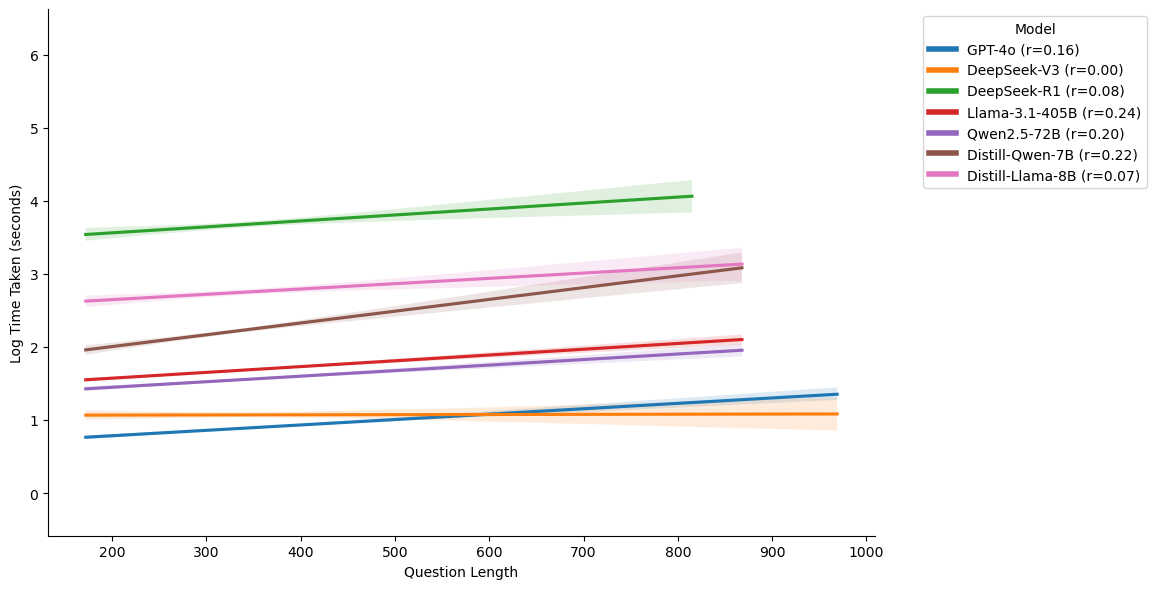

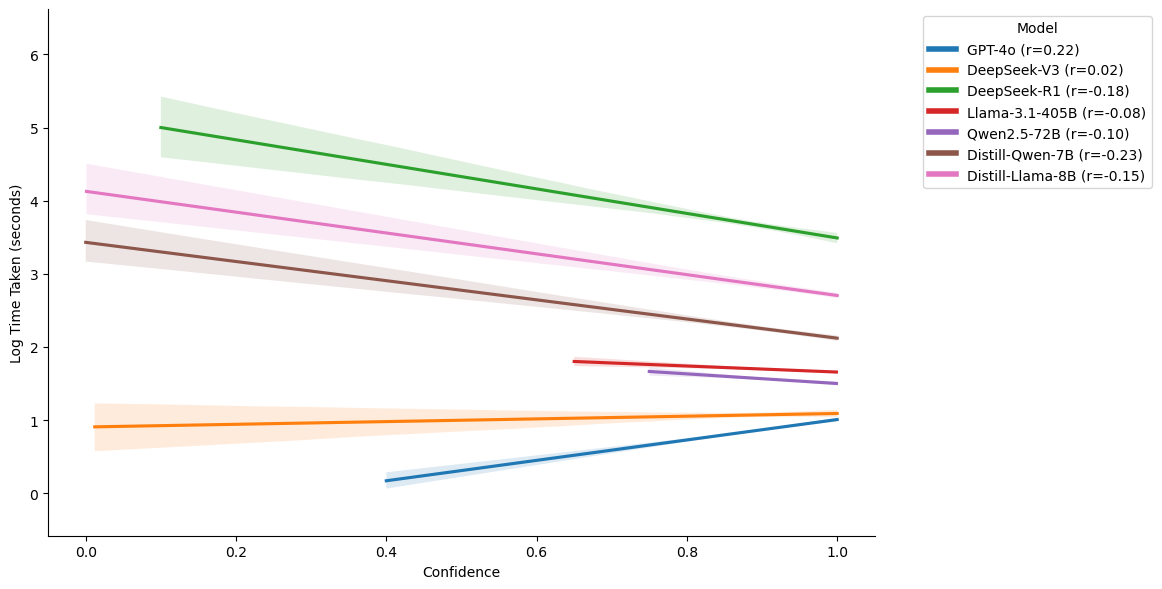

/opt/anaconda3/envs/llms/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/envs/llms/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


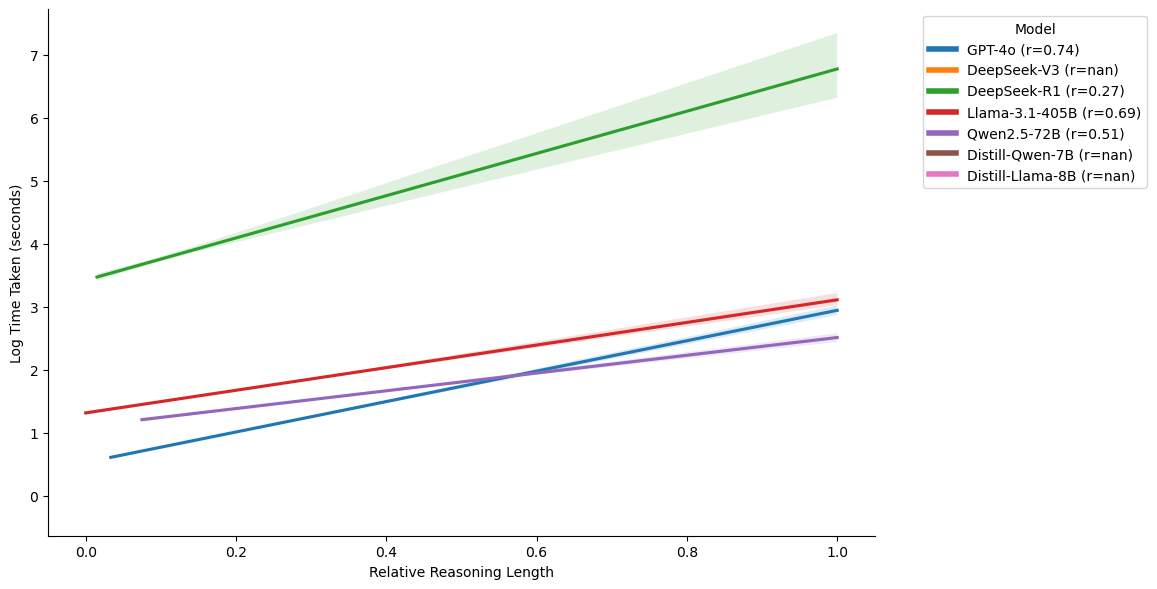

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

save_dir = "/Users/linxy29/Documents/Data/GeneRAG/benchmark/MedMCQA/"
os.makedirs(save_dir, exist_ok=True)

# --- Data Preparation ---
# Assume res is your DataFrame with columns:
# 'model', 'time_taken', 'question_length', 'confidence', and 'reasoning'
res['log_time'] = np.log(res['time_taken'])

# Compute relative reasoning length if not already computed:
max_reasoning_lengths = res.groupby('model')['reasoning'].apply(
    lambda x: x.apply(lambda r: len(str(r)) if isinstance(r, str) else 0).max()
)
res['reasoning_length'] = res['reasoning'].apply(lambda x: len(str(x)) if isinstance(x, str) else 0)
res['relative_reasoning_length'] = res.apply(
    lambda row: row['reasoning_length'] / max_reasoning_lengths[row['model']]
    if row['reasoning_length'] > 0 else 0,
    axis=1
)

# --- Linear Fit with Confidence Interval (Straight Line) ---
# We use lmplot with default linear regression (no lowess) and hide scatter points.
g1 = sns.lmplot(
    data=res,
    x="question_length",
    y="log_time",
    hue="model",
    ci=95,                   # 95% confidence interval (error band)
    scatter_kws={'alpha': 0},# hide individual dots
    height=6, aspect=1.5,
    palette="tab10" # Ensuring consistent coloring
)
g1.set_axis_labels("Question Length", "Log Time Taken (seconds)")
g1._legend.remove()

# --- Adding Correlation to the Legend with Colors ---
ax1 = g1.ax
handles, labels = ax1.get_legend_handles_labels()
# Get colors from the plot
palette = sns.color_palette("tab10", n_colors=len(res['model'].unique()))
color_map = dict(zip(res['model'].unique(), palette))

new_labels = []
new_handles = []
for lab in labels:
    if lab in res['model'].unique():
        sub = res[res['model'] == lab]
        corr = sub['question_length'].corr(sub['log_time'])
        new_labels.append(f"{lab} (r={corr:.2f})")
        new_handles.append(plt.Line2D([0], [0], color=color_map[lab], lw=4))
    else:
        new_labels.append(lab)
        new_handles.append(plt.Line2D([0], [0], color="black", lw=4))

ax1.legend(handles=new_handles, labels=new_labels, title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
g1.savefig(os.path.join(save_dir, "question_length_vs_log_time.pdf"))
plt.show()

# --- Filter Data for Confidence Plot ---
df_filtered_confidence = res[res['confidence'] <= 1].copy()

# --- Linear Fit with Confidence Interval (Straight Line) ---
g2 = sns.lmplot(
    data=df_filtered_confidence,
    x="confidence",
    y="log_time",
    hue="model",
    ci=95,
    scatter_kws={'alpha': 0},
    height=6, aspect=1.5,
    palette="tab10" # Ensuring consistent coloring
)
g2.set_axis_labels("Confidence", "Log Time Taken (seconds)")
g2._legend.remove()

# --- Adding Correlation to the Legend ---
ax2 = g2.ax
handles, labels = ax2.get_legend_handles_labels()
# Get colors from the plot
palette = sns.color_palette("tab10", n_colors=len(res['model'].unique()))
color_map = dict(zip(res['model'].unique(), palette))

new_labels = []
new_handles = []
for lab in labels:
    if lab in df_filtered_confidence['model'].unique():
        sub = df_filtered_confidence[df_filtered_confidence['model'] == lab]
        corr = sub['confidence'].corr(sub['log_time'])
        new_labels.append(f"{lab} (r={corr:.2f})")
        new_handles.append(plt.Line2D([0], [0], color=color_map[lab], lw=4))
    else:
        new_labels.append(lab)
        new_handles.append(plt.Line2D([0], [0], color="black", lw=4))

ax2.legend(handles=new_handles, labels=new_labels, title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
g2.savefig(os.path.join(save_dir, "confidence_vs_log_time.pdf"))
plt.show()

# --- Linear Fit with Confidence Interval (Straight Line) ---
g3 = sns.lmplot(
    data=res,
    x="relative_reasoning_length",
    y="log_time",
    hue="model",
    ci=95,
    scatter_kws={'alpha': 0},
    height=6, aspect=1.5,
    palette="tab10" # Ensuring consistent coloring
)
g3.set_axis_labels("Relative Reasoning Length", "Log Time Taken (seconds)")
g3._legend.remove()

# --- Adding Correlation to the Legend ---
ax3 = g3.ax
handles, labels = ax3.get_legend_handles_labels()

new_labels = []
new_handles = []
for lab in labels:
    if lab in res['model'].unique():
        sub = res[res['model'] == lab]
        corr = sub['relative_reasoning_length'].corr(sub['log_time'])
        new_labels.append(f"{lab} (r={corr:.2f})")
        new_handles.append(plt.Line2D([0], [0], color=color_map[lab], lw=4))
    else:
        new_labels.append(lab)
        new_handles.append(plt.Line2D([0], [0], color="black", lw=4))

ax3.legend(handles=new_handles, labels=new_labels, title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
g3.savefig(os.path.join(save_dir, "relative_reasoning_length_vs_log_time.pdf"))
plt.show()


### Agreement between different models

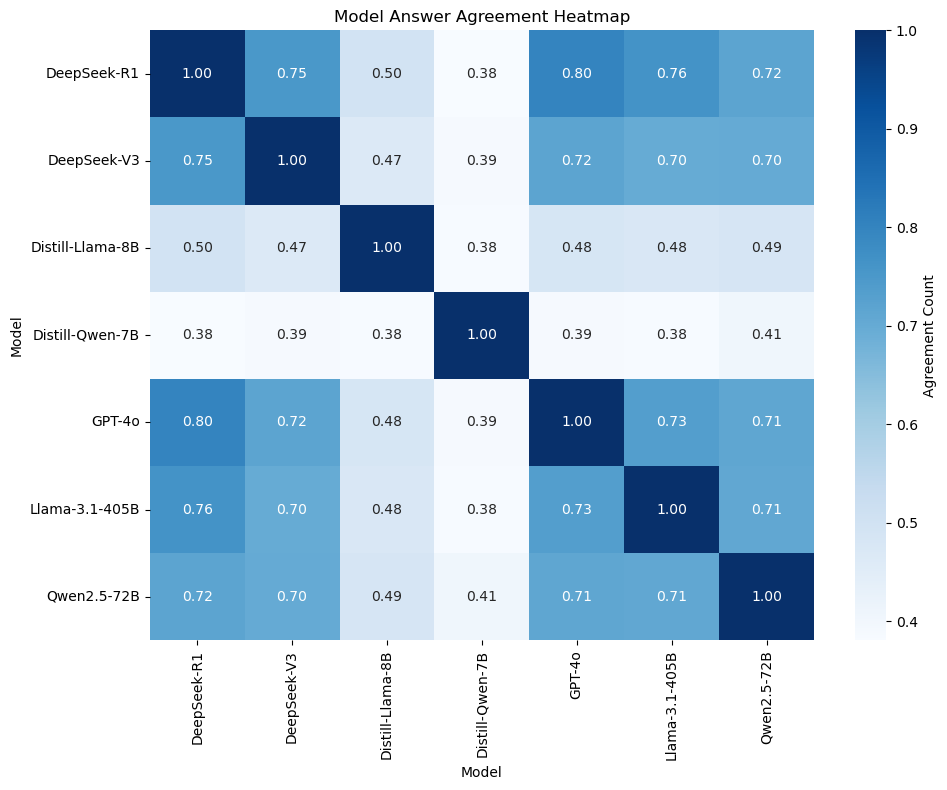

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 预处理数据（假设数据框名为res）
# 筛选有效记录并创建透视表
df_pivot = res.dropna(subset=['option_res']).pivot(
    index='id', 
    columns='model',
    values='option_res'
)

# 2. 计算模型间一致次数
models = df_pivot.columns.tolist()
agreement_matrix = pd.DataFrame(index=models, columns=models, dtype=int).fillna(0)

for i in range(len(models)):
    for j in range(i, len(models)):
        valid_data = df_pivot[[models[i], models[j]]].dropna()
        count = (valid_data.iloc[:,0] == valid_data.iloc[:,1]).sum()
        total = len(valid_data.iloc[:,0])
        prop = count / total
        # 显式转换为整数类型
        agreement_matrix.iloc[i, j] = prop
        agreement_matrix.iloc[j, i] = prop  # 保持对称性

# 3. 绘制热力图
plt.figure(figsize=(10, 8))
sns.heatmap(
    agreement_matrix, 
    annot=True, 
    fmt=".2f",
    cmap='Blues', 
    mask=agreement_matrix.isnull(),
    cbar_kws={'label': 'Agreement Count'}
)
plt.title('Model Answer Agreement Heatmap')
plt.xlabel('Model')
plt.ylabel('Model')
plt.tight_layout()
plt.show()

### different confidence group

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Use pd.qcut to create three groups with equal number of rows based on 'confidence'
res['confidence_level'] = pd.qcut(res['confidence'], q=3, labels=['low', 'medium', 'high'])

# Compute the accuracy for each model within the three confidence levels
accuracy_df = res.groupby(['model', 'confidence_level'])['correct'].mean().reset_index()


/var/folders/mv/5359mrfx7yq8dl6fs3p4gy000000gn/T/ipykernel_65721/3002450083.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  accuracy_df = res.groupby(['model', 'confidence_level'])['correct'].mean().reset_index()


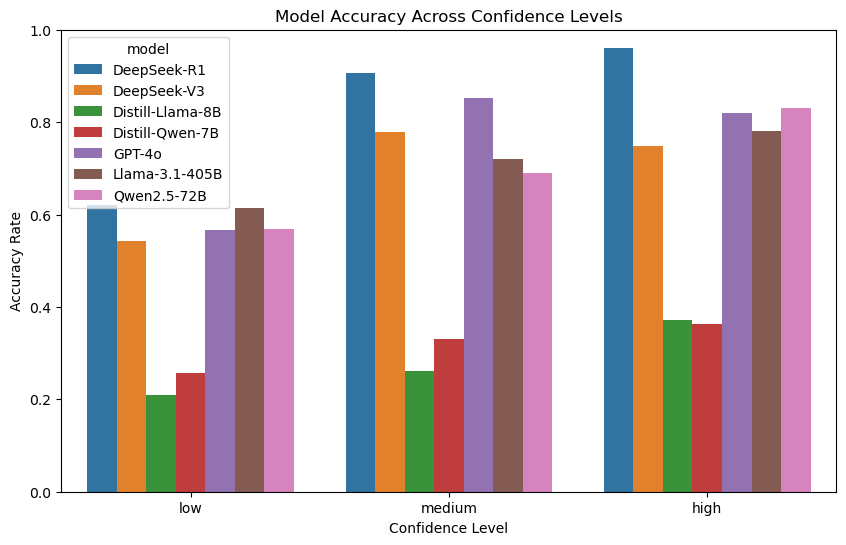

In [13]:
plt.figure(figsize=(10,6))
sns.barplot(x='confidence_level', 
           y='correct',
           hue='model',
           data=accuracy_df)

plt.title('Model Accuracy Across Confidence Levels')
plt.ylabel('Accuracy Rate')
plt.xlabel('Confidence Level')
plt.ylim(0, 1)
plt.show()

## Plot all plots together

In [14]:
## Remove subject_name = Unknown column
acc_df[acc_df['subject_name'] != 'Unknown']

,model,subject_name,accuracy
0,DeepSeek-R1,Anaesthesia,0.928571
1,DeepSeek-R1,Anatomy,0.875000
2,DeepSeek-R1,Biochemistry,0.951807
3,DeepSeek-R1,Dental,0.669643
4,DeepSeek-R1,ENT,0.863636
...,...,...,...
141,Qwen2.5-72B,Psychiatry,0.700000
142,Qwen2.5-72B,Radiology,0.600000
143,Qwen2.5-72B,Skin,0.333333
144,Qwen2.5-72B,Social & Preventive Medicine,0.616667


/var/folders/mv/5359mrfx7yq8dl6fs3p4gy000000gn/T/ipykernel_65721/3438019820.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
/opt/anaconda3/envs/llms/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/envs/llms/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


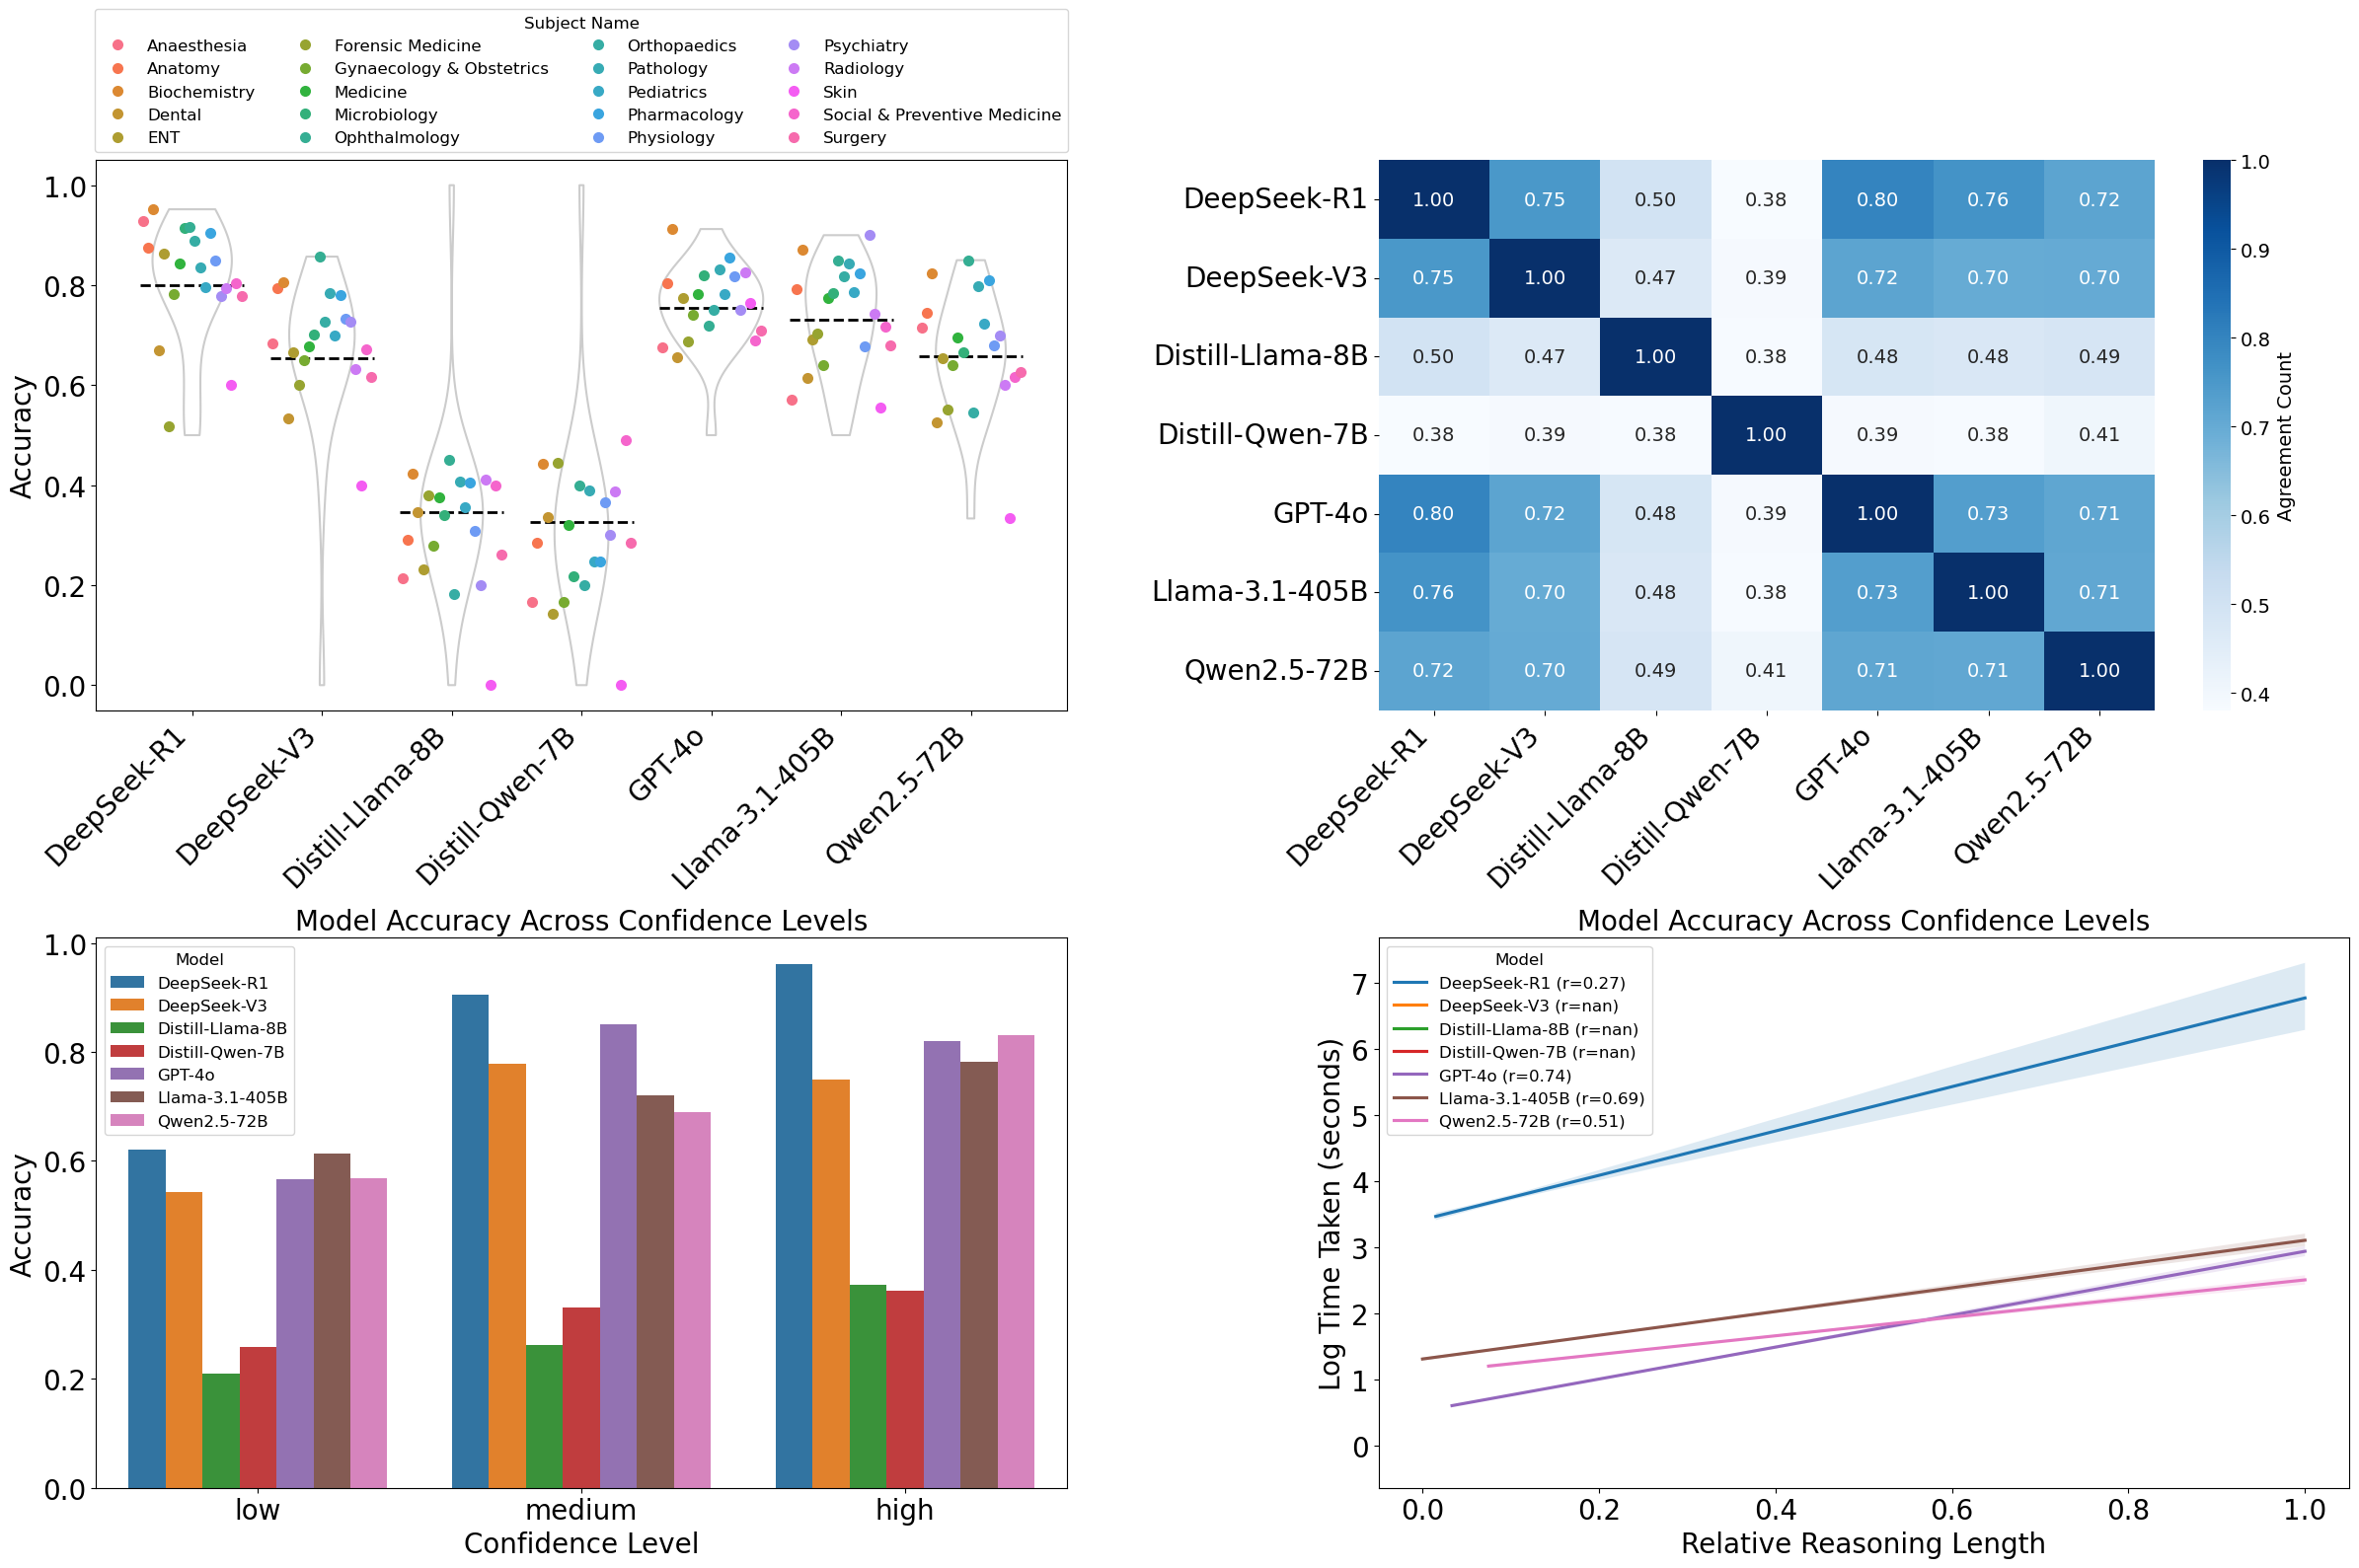

In [34]:
# Create 2x2 subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(24, 16))
fig.subplots_adjust(wspace=0.2,  # space between columns
                    hspace=0.6)  # space between rows

# Define a consistent palette for models (using models from acc_df as an example)
models = sorted(acc_df['model'].unique())
palette = sns.color_palette("tab10", n_colors=len(models))
color_map = dict(zip(models, palette))

## Subplot 1: Violin & Strip Plot
ax1.tick_params(axis='both', which='major', labelsize=20)
model_order = sorted(acc_df['model'].unique())
sns.violinplot(x='model', y='accuracy', data=acc_df, inner=None, color=".8", 
               order=model_order, fill=False, cut=0, ax=ax1)
sns.stripplot(x='model', y='accuracy', data=acc_df[acc_df['subject_name'] != 'Unknown'],
              hue='subject_name', dodge=True, jitter=True, size=8, order=model_order, ax=ax1)
model_means = acc_df.groupby('model')['accuracy'].mean().reset_index()
for i, model in enumerate(model_order):
    mean_val = model_means.loc[model_means['model'] == model, 'accuracy'].values[0]
    ax1.hlines(mean_val, i - 0.4, i + 0.4, colors='black', linestyles='--', lw=2)
ax1.set_ylabel('Accuracy', fontsize=20)
ax1.set_xlabel("")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.legend(title='Subject Name', bbox_to_anchor=(0.5, 1), loc='lower center', ncol=4, fontsize=12, title_fontsize=12)

## Subplot 2: Heatmap
ax2.tick_params(axis='both', which='major', labelsize=20)
heatmap = sns.heatmap(agreement_matrix, 
            annot=True, fmt=".2f",                  # Format for the annotation text
            annot_kws={"fontsize": 14}, # Increase font size of numbers in each cell
            cmap='Blues', 
            mask=agreement_matrix.isnull(),
            cbar_kws={'label': 'Agreement Count'},             # color map
            ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
# Now adjust the colorbar fonts
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)                  # Font size for colorbar ticks
cbar.set_label("Agreement Count", fontsize=14)     # Font size for colorbar label

## Subplot 3: Barplot with consistent colors
ax3.tick_params(axis='both', which='major', labelsize=20)
sns.barplot(x='confidence_level', 
            y='correct',
            hue='model',
            data=accuracy_df,
            ax=ax3,
            palette=color_map)  # Use the same color mapping
ax3.set_title('Model Accuracy Across Confidence Levels', fontsize=20)
ax3.set_ylabel('Accuracy', fontsize=20)
ax3.set_xlabel('Confidence Level', fontsize=20)
ax3.legend(title='Model', bbox_to_anchor=(0, 1), loc='upper left', fontsize=12, title_fontsize=12)

## Subplot 4: Regression lines with consistent colors
ax4.tick_params(axis='both', which='major', labelsize=20)
for model in models:
    sub_df = res[res['model'] == model]
    corr = sub_df['relative_reasoning_length'].corr(sub_df['log_time'])
    label = f"{model} (r={corr:.2f})"
    sns.regplot(data=sub_df,
                x="relative_reasoning_length",
                y="log_time",
                ci=95,
                scatter_kws={'alpha': 0},
                line_kws={'label': label},
                color=color_map[model],
                ax=ax4)
ax4.set_title('Model Accuracy Across Confidence Levels', fontsize=20)
ax4.set_xlabel("Relative Reasoning Length", fontsize=20)
ax4.set_ylabel("Log Time Taken (seconds)", fontsize=20)
ax4.legend(title="Model", bbox_to_anchor=(0, 1), loc='upper left', fontsize=12, title_fontsize=12)

plt.tight_layout()
plt.savefig('/Users/linxy29/Documents/Files/other collaboration/benchmark/f2_MedMCQA.pdf')
plt.show()